In [86]:
import pandas as pd
import numpy as np
import ast
from tqdm.autonotebook import tqdm
import shap
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from datetime import date
from dateutil.relativedelta import relativedelta

from ModelProcessing.CategoricalEncoder import Encoder
from ModelProcessing.Filter_fights import Subset
from ModelProcessing.EvaluationPlots import LiftGainChart, BuildROCandPrecisionRecall
from ModelProcessing.GetDifferenceBetweenFighterAttributes import GetTheDifferenceBetweenFighterAttributes
from PreProcessing.Imputer import Imputer
pd.set_option('display.max_columns', 200)

ufc = pd.read_csv('C:/Users/egnke/PythonCode/UFC/Cost-Sensitive-Modeling-UFC/data/engineered_features.csv')
print(ufc.shape)
ufc.tail()

(4310, 102)


R_fighter            B_fighter  Average_Odds_f1  Average_Odds_f2  \
4305           Dan Ige        Edson Barboza            127.0           -119.0   
4306   Claudia Gadelha          Angela Hill           -225.0            225.0   
4307     Cortney Casey  Mara Romero Borella           -164.0            167.0   
4308     Darren Elkins        Nate Landwehr           -117.0            110.0   
4309  Alistair Overeem          Walt Harris            138.0           -141.0   

            date  title_bout                win_by         weight_class  \
4305  2020-05-16       False      Decision - Split        Featherweight   
4306  2020-05-16       False      Decision - Split  Women's Strawweight   
4307  2020-05-16       False            Submission    Women's Flyweight   
4308  2020-05-16       False  Decision - Unanimous        Featherweight   
4309  2020-05-16       False                KO/TKO          Heavyweight   

      red_fighters_elo  blue_fighters_elo  red_Fighter_Odds  \
4305       1365.731594        1321.063221          0.440529   
4306       1190.926597        1130.800206          0.692308   
4307       1001.684925         903.898766          0.621212   
4308       1255.694220         862.500000          0.539171   
4309       1255.593400        1158.000020          0.420168   

      blue_Fighter_Odds Winner  R_distance_beaten  R_distance_lost  \
4305           0.543379    Red           5.151829         8.008405   
4306           0.307692    Red           1.909069         3.497536   
4307           0.374532    Red           5.194975         5.142925   
4308           0.476190   Blue           4.511560         4.805342   
4309           0.585062    Red           4.111669         4.938344   

      R_Fight_Number  R_Stance  R_Height_cms  R_Reach_cms  R_age  \
4305             7.0  Orthodox        170.18       180.34   28.0   
4306            11.0  Orthodox        162.56       160.02   31.0   
4307            10.0  Orthodox        170.18       170.18   33.0   
4308            20.0  Orthodox        177.80       180.34   36.0   
4309            17.0  Orthodox        193.04       203.20   39.0   

      R_WinLossRatio                                     R_Beaten_Names  \
4305        0.833333  ['Mike Santiago', 'Jordan Griffin', 'Danny Hen...   
4306        0.600000  ['Tina Lahdemaki', 'Jessica Aguilar', 'Cortney...   
4307        0.444444  ['Cristina Stanciu', 'Randa Markos', 'Jessica ...   
4308        0.684211  ['Duane Ludwig', 'Michihiro Omigawa', 'Tiequan...   
4309        0.562500  ['Brock Lesnar', 'Frank Mir', 'Stefan Struve',...   

                                        R_Lost_to_names  R_RingRust  \
4305                                     ['Julio Arce']   74.926631   
4306  ['Joanna Jedrzejczyk', 'Joanna Jedrzejczyk', '...   96.298589   
4307  ['Joanne Calderwood', 'Claudia Gadelha', 'Feli...  138.716497   
4308  ['Charles Oliveira', 'Chad Mendes', 'Jeremy St...  107.517183   
4309  ['Antonio Silva', 'Travis Browne', 'Ben Rothwe...   92.473645   

      R_Winning_Streak  R_Losing_Streak  R_AVG_fight_time  \
4305               5.0              0.0         10.278333   
4306               1.0              0.0         14.803000   
4307               0.0              1.0         12.411111   
4308               0.0              2.0         11.552105   
4309               0.0              1.0          8.885000   

      R_total_title_bouts  R_Beaten_Similar  R_Takedown_Defense  \
4305                  0.0                 0            0.740000   
4306                  1.0                 2            0.775510   
4307                  0.0                 0            0.275000   
4308                  0.0                 0            0.590909   
4309                  1.0                 1            0.619048   

      R_Takedown Accuracy  R_Strikes_Per_Minute  R_Log_Striking_Ratio  \
4305             0.542582             14.068946              0.321518   
4306             0.507853              7.416092              0.039973   

In [87]:
def create_a_merge_column(df, fighter_one, fighter_two, date):
    
    df['merge'] = df[fighter_one] + df[fighter_two] 
    df['merge'] = df['merge'].apply(lambda x: x.replace(" ", "").replace(".",""))
    df['merge'] = df['merge'].apply(lambda x: ''.join(sorted(x)))
    df['merge'] = df['merge'] + df[date].astype(str)

    return(df)

data = pd.read_csv('C:/Users/egnke/PythonCode/UFC/Cost-Sensitive-Modeling-UFC/data/data.csv')

data = create_a_merge_column(data, 'R_fighter', 'B_fighter', 'date')
ufc = create_a_merge_column(ufc, 'R_fighter', 'B_fighter', 'date')
ufc = ufc.merge(data, on='merge',
                 how='left', suffixes=('', '_y'))
ufc.drop(ufc.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)

In [88]:
# Subset Data
my_filter = Subset(ufc)
my_filter.subset_on_number_of_fights(number_of_fights=3)
my_filter.subset_on_draws
filtered_ufc = my_filter.df

# Encode Data
ufc_encoder = Encoder(filtered_ufc)
ufc_encoder.encode_weight_class
ufc_encoder.encode_title_bout
ufc_encoder.encode_winner
ufc_encoder.Difference_in_stances
encoded_ufc = ufc_encoder.df

# Impute missing values
imputer = Imputer(encoded_ufc)
cleaned_ufc = imputer.impute('bfill')
cleaned_ufc = imputer.impute_missing_values()

0%|          | 0/690 [00:00<?, ?it/s]Original Shape with all fights: (4310, 219)
New Shape with fighters over 3 fights (1607, 219)
Original Shape including Draws: (1607, 219)
New Shape with excluding draws(1579, 219)
100%|██████████| 690/690 [01:08<00:00, 10.07it/s]These Columns have Missing Values['R_distance_beaten', 'B_Takedown_Defense', 'B_Takedown Accuracy', 'B_distance_beaten', 'Referee']
Finished Imputation



In [90]:
def drop_cols(df):
    df = df.copy()
    df.drop(['R_fighter', 'B_fighter', 
                  'win_by','weight_class','Winner','B_Beaten_Names', 'B_Lost_to_names', 'R_Beaten_Names', 'R_Lost_to_names',
                  'B_Stats_of_Opponents_they_have_beaten',  'B_Stats_of_Opponents_they_have_lost_to',
                  'R_Stats_of_Opponents_they_have_beaten',  'R_Stats_of_Opponents_they_have_lost_to',],  axis=1, inplace=True)

    numeric_cols = df.select_dtypes([np.int, np.int64 , np.float, np.bool]).dtypes.index
    print('The following columns have been removed: '+ str(set(df.columns).symmetric_difference(numeric_cols)))
    
    new_df = df[numeric_cols]
    new_df['date'] = df['date']
    
    return new_df

ufc_cleaned = drop_cols(cleaned_ufc)

The following columns have been removed: {'date', 'Referee', 'location', 'merge'}


In [91]:
difference = GetTheDifferenceBetweenFighterAttributes(ufc_cleaned)
difference.get_difference_between_fighters_stats(cols_to_keep_whole=['fight_weight'])
ufc_cleaned = difference.get_data()

In [93]:
class MakeBet:

  def __init__(self):
      '''
      MakeBet().Place_bet(stake=20, red_fighter_odds=500,
                    blue_fighter_odds=-500, prediction=0, winner=0)
      '''
      pass


  def Place_bet(self, stake, red_fighter_odds, blue_fighter_odds, prediction, winner):

    if prediction == winner:

      if prediction == 1:
        winnings = self.Calculate_Winnings(stake, red_fighter_odds)
        payout   = winnings + stake
        return payout

      else:
        winnings = self.Calculate_Winnings(stake, blue_fighter_odds)
        payout   = winnings + stake
        return payout
    
    else:

      return -stake


  @staticmethod
  def Calculate_Winnings(stake, odds):

    if odds > 0:
      winnings = (stake*odds)/100

    else:
      winnings = (stake/odds) * 100

    return abs(winnings)



class BackTest:
    

    def __init__(self, df, model, date_range, y, sample_weights = False):

        self.model = model
        self.date_range = date_range
        self.sample_weights = sample_weights
        self.df = df.copy()
        self.df = self.create_datetime_index(self.df, 'date')
        self.most_recent_date = self.df.index.max()
        self.dates = self.df.index.unique().to_list()
        self.y = y


    @staticmethod
    def create_datetime_index(df, date_col):

        if not date_col in df.columns:
            raise AttributeError('The column ' + str(date_col) + ' does not exist!')

        datetime_series = pd.to_datetime(df[date_col])
        datetime_index = pd.DatetimeIndex(datetime_series.values)
        df.set_index(datetime_index, inplace=True)
        df.drop(date_col, axis=1, inplace=True)
        return df


    @staticmethod
    def check_if_tuple(obj):

        if isinstance(obj, tuple):
            return True
        else:
            return False

    
    def initlize_index(self):

        df = self.df.copy()
        if self.check_if_tuple(self.date_range):

            filtered_df = df[self.date_range[0]:self.date_range[1]]
            index = self.dates.index(max(filtered_df.index))

            return index

        else:

            filtered_df = df[:self.date_range]
            index = self.dates.index(max(filtered_df.index))

            return index


    def filter_data_by_index(self, df, date_range):

        df = df.copy()
        if self.check_if_tuple(date_range):

            X_train = df[date_range[0]:date_range[1]]
            y_train = X_train.pop(self.y)

            index = self.dates.index(max(X_train.index))
            X_test = df[self.dates[index+1]:self.dates[index+1]]
            y_test = X_test.pop(self.y)

            weights = X_train.pop('fight_weight')
            X_test.pop('fight_weight')

            return X_train, X_test, y_train, y_test, index, weights

        else:

            X_train = df[:date_range]
            y_train = X_train.pop(self.y)

            index = self.dates.index(max(X_train.index))
            X_test = df[self.dates[index+1]:self.dates[index+1]]
            y_test = X_test.pop(self.y)

            weights = X_train.pop('fight_weight')
            X_test.pop('fight_weight')

            return X_train, X_test, y_train, y_test, index, weights


    def update_date_range(self, date_range, index):

        if self.check_if_tuple(date_range):
            new_date   = self.dates[index+1]
            new_date_range = (date_range[0], new_date)
            return new_date_range

        else:
            new_date   = self.dates[index+1]
            new_date_range = new_date
            return new_date_range


    @staticmethod
    def place_bets(row, bookie, stake):

        return bookie.Place_bet(stake=stake, red_fighter_odds=row['Red Odds'],
                    blue_fighter_odds=row['Blue Odds'], prediction=row['Predicted'], winner=row['Actual'])


    def fit(self):

        index = self.initlize_index()
        probas = []
        y_true = []
        red_fighter_odds  = []
        blue_fighter_odds = []
        date = []
        while self.dates[index+1] != self.most_recent_date:
            
            X_train, X_test, y_train, y_test, index, weights = self.filter_data_by_index(self.df, self.date_range)

            X_train.pop('Average_Odds_f1')
            X_train.pop('Average_Odds_f2')

            date.append(X_test.index.values)
            red_fighter_odds.append(X_test.pop('Average_Odds_f1'))
            blue_fighter_odds.append(X_test.pop('Average_Odds_f2'))

            if self.sample_weights == True:
                probabilities = self.model.fit(X_train, y_train, sample_weight=weights).predict_proba(X_test)[:,1]
            else:
                probabilities = self.model.fit(X_train, y_train).predict_proba(X_test)[:,1]

            probas.append(probabilities)
            y_true.append(y_test.values)

            self.date_range = self.update_date_range(self.date_range, index)
            
            print('Training range: (' + str(X_train.index.min()) +  ', ' + str(X_train.index.max()) +')' + '    Test range: ' \
                   + str(X_test.index.min()) + ', ' + str(X_test.index.max()) +')' )


        date = np.concatenate(date).ravel()
        y_true = np.concatenate(y_true).ravel()
        probas = np.concatenate(probas).ravel()
        red_fighter_odds  = np.concatenate(red_fighter_odds).ravel()
        blue_fighter_odds = np.concatenate(blue_fighter_odds).ravel()

        preds = np.where(probas > 0.45, 1, 0)
        print(f'{classification_report(y_true, preds)}')

        LiftGainChart(y_true=y_true, probas=probas)
        BuildROCandPrecisionRecall(y_true=y_true, probas=probas)


        data = pd.DataFrame({
                      'Date':date,
                      'Actual':y_true,
                      'Predicted':preds,
                      'Probas':probas,
                      'Red Odds': red_fighter_odds,
                      'Blue Odds': blue_fighter_odds})


        bookie = MakeBet()
        data['Money_bet'] = data.apply(lambda x: self.place_bets(x, bookie, 10), axis=1)
        data['Money_Made'] = data['Money_bet'].cumsum()

        plt.figure(figsize=(10, 8))
        plt.title('Money from Bets')
        plt.ylabel('Money Dollars')
        plt.xlabel('Date')
        plt.plot(data['Date'], data['Money_Made'])
        plt.xticks(rotation='vertical')
        plt.show()


six_months_ago = date.today() + relativedelta(months=-6)
model = RandomForestClassifier(criterion='gini', max_depth=4, random_state=40)

backtest = BackTest(ufc_cleaned, model, date_range=six_months_ago, y='Winner_encoded', sample_weights=False)
backtest.fit()

KeyError: 'fight_weight'

In [64]:
def check(clf, X, y):

    print(f'{classification_report(y, clf.predict(X))}')
    shap.initjs()
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X)
    return shap.summary_plot(shap_values[1], X, plot_type='dot')


def cross_validate_catboost(X, y, **kwargs):
    import catboost, utils
    models = cross_validate(
             catboost.CatBoostClassifier(od_type='Iter',
                                         od_wait=10,
                                         eval_metric='AUC', 
                                         **kwargs
                                         ),
                             X, y,
                             fit=lambda m,Xt,yt,Xv,yv: m.fit(Xt, yt, eval_set=(Xv,yv),
                             cat_features=np.where(X.dtypes == 'category')[0],
                             verbose=0))
                             
    return pd.DataFrame(models)


def balancing_params(y):
    counts = y.value_counts()
    return { 'class_names': list(counts.index), 'class_weights': len(y) / counts.values }


X = ufc_cleaned.copy()
X.pop('date')
y = X.pop('Winner_encoded')


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
model_forest = RandomForestClassifier(criterion='gini', max_depth=4, class_weight='balanced')
model_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

precision    recall  f1-score   support

           0       0.64      0.85      0.73       519
           1       0.86      0.67      0.75       744

    accuracy                           0.74      1263
   macro avg       0.75      0.76      0.74      1263
weighted avg       0.77      0.74      0.74      1263



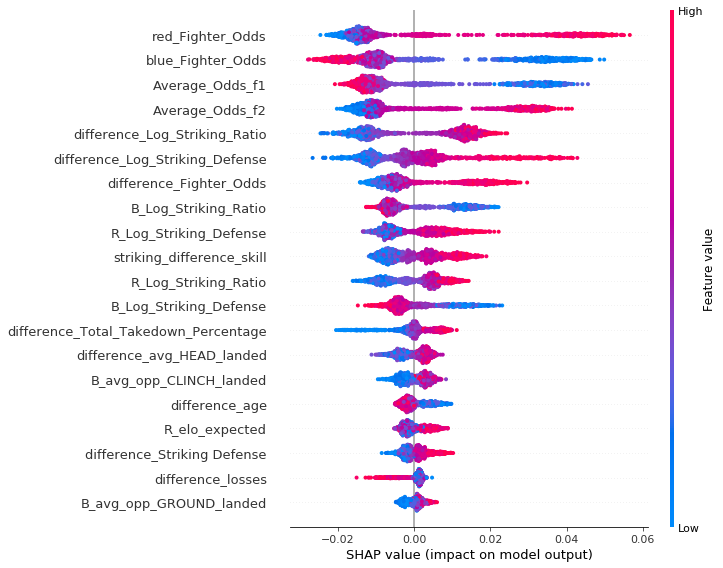

In [65]:
check(model_forest, X_train, y_train)

precision    recall  f1-score   support

           0       0.58      0.79      0.67       125
           1       0.82      0.62      0.70       191

    accuracy                           0.69       316
   macro avg       0.70      0.70      0.69       316
weighted avg       0.72      0.69      0.69       316



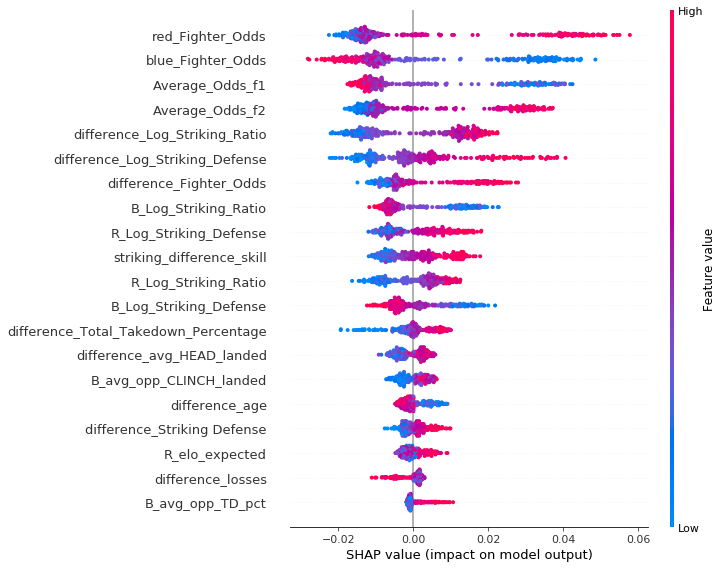

In [66]:
check(model_forest, X_test, y_test)

precision    recall  f1-score   support

           0       0.66      0.79      0.72       510
           1       0.84      0.72      0.78       753

    accuracy                           0.75      1263
   macro avg       0.75      0.76      0.75      1263
weighted avg       0.77      0.75      0.75      1263



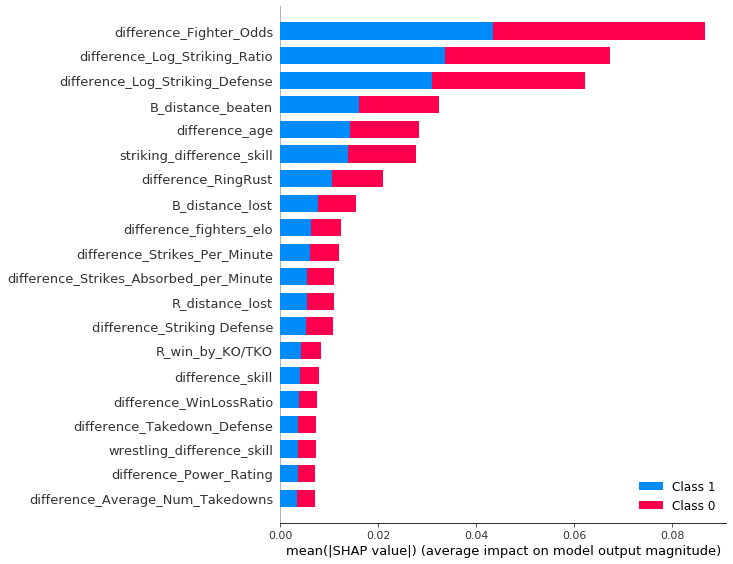

In [21]:
check(model_forest, X_train, y_train)

In [56]:
test = ufc.copy()
test['Elo_winner'] = np.where(test['R_elo_expected'] > test['B_elo_expected'], 1, 0)
ufc.tail()

B_Stance  B_Height_cms  B_Reach_cms  B_age  \
4305            23.0  Orthodox        180.34       190.50   34.0   
4306            14.0  Orthodox        160.02       162.56   35.0   
4307             5.0  Orthodox        167.64       175.26   33.0   
4308             2.0  Orthodox        175.26       182.88   31.0   
4309            12.0  Southpaw        195.58       195.58   36.0   

      B_WinLossRatio  B_RingRust  B_Winning_Streak  B_Beaten_Similar  \
4305        0.636364   65.114311               0.0                 0   
4306        0.461538  119.932513               3.0                 0   
4307        0.500000  145.273191               0.0                 0   
4308        0.000000   79.195959               0.0                 0   
4309        0.545455  140.714707               4.0                 0   

      B_Losing_Streak  B_AVG_fight_time  B_total_title_bouts  \
4305              2.0         11.050000                  0.0   
4306              0.0         12.502308                  0.0   
4307              1.0         11.000000                  0.0   
4308              1.0               NaN                  0.0   
4309              0.0          6.165455                  0.0   

      B_Takedown_Defense  B_Takedown Accuracy  B_distance_beaten  \
4305            0.790726             0.363636           5.275290   
4306            0.541667             0.708333           3.830236   
4307            0.750000             0.516667           3.702734   
4308                 NaN                  NaN        9999.000000   
4309            0.735000             0.761905           4.686816   

      B_distance_lost  B_Strikes_Per_Minute  B_Striking Accuracy  \
4305         4.583176              8.391682             0.455230   
4306         2.884138              6.916503             0.461628   
4307         2.012612              3.672056             0.407340   
4308         2.929251                   NaN                  NaN   
4309         4.859632             10.441600             0.370594   

      B_Log_Striking_Ratio  B_Strikes_Absorbed_per_Minute  B_Striking Defense  \
4305              0.230896                       4.415949            0.592981   
4306              0.081435                       5.250654            0.631172   
4307             -0.296435                       2.256894            0.793759   
4308             -0.257065                            NaN                 NaN   
4309              0.869234                       6.700818            0.653076   

      B_knockdows_per_minute  B_Submission Attempts  B_Average_Num_Takedowns  \
4305                0.068886               0.045455                 0.495580   
4306                0.005128               0.153846                 0.509221   
4307                0.000000               1.476378                 2.553603   
4308                     NaN                    NaN                      NaN   
4309                0.864204               0.090909                 0.408773   

      B_win_by_Decision_Majority  B_win_by_Decision_Split  \
4305                    0.043478                 0.043478   
4306                    0.000000                 0.000000   
4307                    0.000000                 0.200000   
4308                    0.000000                 0.000000   
4309                    0.000000                 0.000000   

      B_win_by_Decision_Unanimous  B_win_by_KO/TKO  B_win_by_Submission  \
4305                     0.217391         0.304348                  0.0   
4306                     0.357143         0.071429                  0.0   
4307                     0.000000         0.000000                  0.2   
4308                     0.000000         0.000000                  0.0   
4309                     0.000000         0.500000                  0.0   

      B_win_by_TKO_Doctor_Stoppage  B_Power_Rating  blue_skill  \
4305                      0.000000        0.143873   35.216548   
4306                      0.071429        0.002467   24.008

precision    recall  f1-score   support

           0       0.63      0.76      0.69       125
           1       0.82      0.71      0.76       191

    accuracy                           0.73       316
   macro avg       0.72      0.73      0.72       316
weighted avg       0.74      0.73      0.73       316



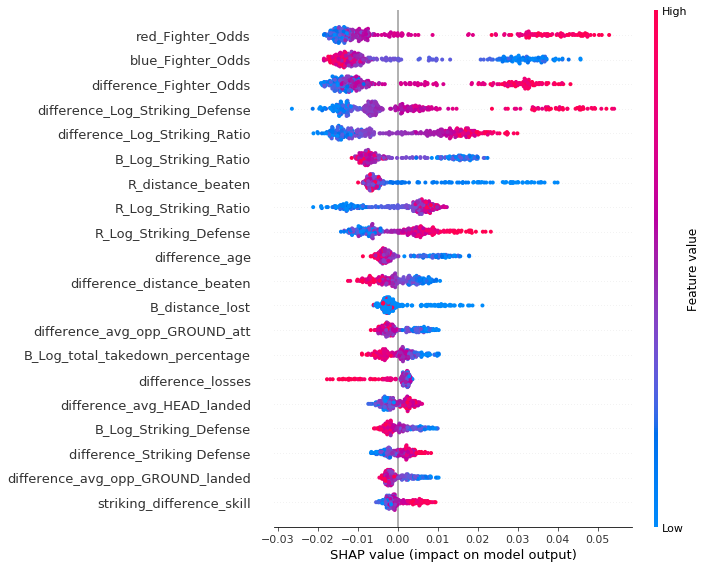

In [182]:
check(model_forest, X_test, y_test)

In [24]:
X[['difference_Fighter_Odds','difference_Log_Striking_Ratio','difference_Log_Striking_Defense',
                    'difference_age', 'difference_RingRust','striking_difference_skill','difference_fighters_elo','difference_Takedown_Defense',
                    'wrestling_difference_skill','difference_Power_Rating','g_and_p_difference_skill','jiujitsu_difference_skill','R_win_by_KO/TKO']]

difference_Fighter_Odds  difference_Log_Striking_Ratio  \
169                  0.472990                       1.102452   
171                  0.136033                       0.197858   
189                  0.178641                       0.786744   
198                 -0.412069                       1.491458   
219                  0.506691                       0.026617   
...                       ...                            ...   
4305                -0.102850                       0.090622   
4307                 0.246680                       0.823087   
4303                 0.296228                       1.003269   
4304                -0.026066                      -0.619278   
4309                -0.164894                       0.257174   

      difference_Log_Striking_Defense  difference_age  difference_RingRust  \
169                         -0.039221           -10.0            10.883437   
171                         -0.115100            -7.0             8.403500   
189                          0.361191             7.0           -20.753831   
198                          0.287114             6.0            13.129770   
219                          0.232953             6.0            -7.816285   
...                               ...             ...                  ...   
4305                         0.061686            -6.0             9.812320   
4307                        -0.377351             0.0            -6.556693   
4303                         0.194499            -5.0             1.080584   
4304                        -0.208212             3.0           -31.262787   
4309                        -0.133221             3.0           -48.241062   

      striking_difference_skill  difference_fighters_elo  \
169                    9.588448                24.195311   
171                    1.864602                 2.521583   
189                    6.780566                 7.033930   
198                    4.981481                -3.852588   
219                    2.112408                66.823918   
...                         ...                      ...   
4305                  -1.486498               -14.705249   
4307                   3.541576                23.094774   
4303                   0.240543               -77.534748   
4304                  -0.160089                11.790678   
4309                   3.579476                10.774048   

      difference_Takedown_Defense  wrestling_difference_skill  \
169                     -0.493386                    1.979016   
171                     -0.083333                    0.980880   
189                     -0.107071                    6.786315   
198                     -0.055556                   -1.961440   
219                      0.498932                    9.787561   
...                           ...                         ...   
4305                    -0.050726                    0.000990   
4307                    -0.475000                   -9.751309   
4303                     0.089021                    0.530992   
4304                    -0.078720                    0.878551   
4309                    -0.115952                   -5.861912   

      difference_Power_Rating  g_and_p_difference_skill  \
169                 -0.111111                  3.408491   
171                  0.110317                  1.864602   
189                 -0.045834                  6.148363   
198                  0.016667                  8.021881   
219                 -0.027775                 -3.338966   
...                       ...                       ...   
4305                -0.098993                 15.771376   
4307                 0.018251                 -4.034090   
4303                -0.003991                  7.918364   
4304                 0.032938                 -8.017109   
4309                 0.268679                 -3.866091   

      jiujitsu_difference_skill  R_win_by_KO/TKO  
169                  -15.063475       

In [80]:
data = pd.read_csv('C:/Users/egnke/PythonCode/UFC/Cost-Sensitive-Modeling-UFC/data/total_fight_data.csv',sep=';')

In [82]:
data.win_by.value_counts()

Decision - Unanimous       1913
KO/TKO                     1774
Submission                 1139
Decision - Split            540
TKO - Doctor's Stoppage      75
Decision - Majority          62
Overturned                   38
DQ                           17
Could Not Continue           15
Other                         2
Name: win_by, dtype: int64